<strong> Import all libraires that will be used </strong>

In [1]:
from utils import PaintingsDataset, Generator, Unet_Discriminator, Unet_Generator, unet_d_criterion_without_cutmix
import random
import torch
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.optim as optim
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

<strong> Initializing the paintings dataset </strong>

In [2]:
# Building the dataset
image_dir = '../../data/resized/resized/'

# Transformations to normalize the data before dataloader
transform = transforms.Compose([
    transforms.Resize((128,128)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])


# Initializing the dataset
paintings = PaintingsDataset(image_dir, transform)

<strong> Sampling an element from the dataset and plotting it </strong>

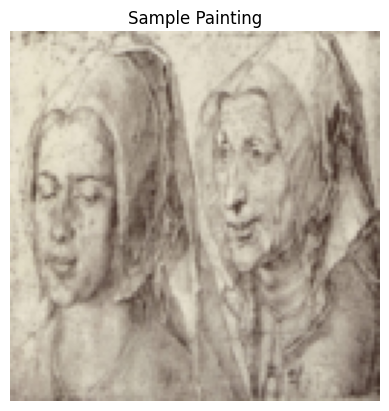

In [3]:
# Sampling randomly an element from the dataset
n = len(paintings)
integer = random.randint(0,n)

# Sampled image
image = paintings[integer].numpy()*0.5 + 0.5 # De-normalizing the image

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()

<strong> Intializing the Dataloader </strong>

In [4]:
dataloader = DataLoader(paintings, batch_size=16)

<strong> Initializing the parameters of the model </strong>

In [5]:
# Model's parameters
latent_dim = 40
channels_out = 3
channels_in = 3

# Intializing the models
G = Generator(latent_dim, channels_out)
D = Unet_Discriminator(3, 2)

<strong> Sampling a vector to plot the fake image generated by the Generator </strong>

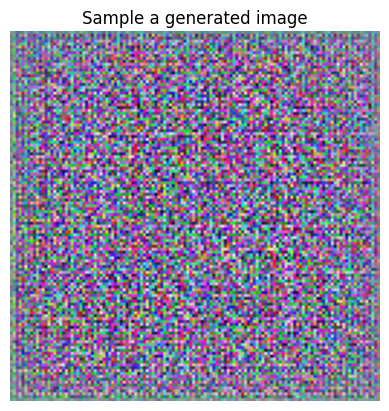

In [6]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G(noise)

# De-normalizing the image
image_generated = fake_images.detach().numpy().reshape((3,128,128))*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample a generated image')
plt.show()

<strong> Let build the training loop</strong>

In [ ]:
torch.autograd.set_detect_anomaly(True)

# Parameters
input_channels = 3
n_classes = 2
k = 1  # Steps to train generator
latent_dim = 40
epochs = 300  # Total number of epochs

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Initialize models
G_unet = Unet_Generator(latent_dim, channels_out).to(device)  # Ensure latent_dim and channels_out are defined
D = Unet_Discriminator(input_channels, n_classes=n_classes).to(device)

# Loss function and optimizers
criterion = unet_d_criterion_without_cutmix
optimizer_g_unet = optim.Adam(G_unet.parameters(), lr=1e-4, betas=(0.99, 0.99))
optimizer_d_unet = optim.Adam(D.parameters(), lr=5e-4, betas=(0.99, 0.99))

# For evaluation
epoch_eval = epochs // 10

fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500
N = len(paintings)
indices = random.sample(range(N), n_samples)

real_images_eval = torch.stack([paintings[idx] for idx in indices])
fid.update(real_images_eval, real=True)

FID_values = []
D_loss = []
G_loss =  []

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):

        # Train discriminator
        real_images = batch.to(device)
        batch_size = real_images.size(0)

        # Labels for real and fake images
        labels_real = torch.ones(batch_size, 1, device=device)
        labels_fake = torch.zeros(batch_size, 1, device=device)

        # Train discriminator with real images
        D.zero_grad()
        output = D(real_images)
        loss_d_real = criterion(output, labels_real, batch_size)

        # Train discriminator with fake images
        noise = torch.rand(batch_size, latent_dim, 1, 1, device=device) * 2 - 1
        fake_images = G_unet(noise)
        output = D(fake_images.detach())
        loss_d_fake = criterion(output, labels_fake, batch_size)

        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optimizer_d_unet.step()

        if epoch % k == 0:
            # Train generator
            G_unet.zero_grad()
            output = D(fake_images)
            loss_g = criterion(output, labels_real, batch_size)  # Labels for generator are real
            loss_g.backward()
            optimizer_g_unet.step()
    
    if epoch % epoch_eval == 0:
        # Eval mode
        G_unet_eval = G_unet.eval()

        # Generating fake images
        noise = torch.randn(n_samples, latent_dim, 1, 1, device=device)
        fake_images_eval = G_unet_eval(noise).to(torch.device('cpu'))
        fid.update(fake_images_eval, real=False)
        fid_value = fid.compute().item()
        FID_values.append(fid_value)

        # Train mode
        G_unet.train()

    end_time = time.time()
    if epoch % k == 0:
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')

    print(f'Epoch {epoch + 1} duration: {end_time - start_time}')


cuda


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

<strong> Generating some examples using the trained generator </strong>

In [ ]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

G_unet_test = G_unet.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

image_noise = fake_images.detach().numpy().reshape((3,128,128))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

<strong> Plotting Losses <strong>

In [ ]:
# Assuming G_loss and D_loss are defined
ng = len(G_loss)
nd = len(D_loss)
time_steps_g = [i for i in range(ng)]
time_steps_d = [i for i in range(nd)]


plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps_g, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps_d, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID values <strong>

In [ ]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)